In [43]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import emoji
from wordcloud import WordCloud
from PIL import Image
from stop_words import get_stop_words


# Premier dataset

In [2]:
data1 = pd.read_csv("data/dev-1/dev-1-task-1.csv", header=None)

In [3]:
data1.columns = ["tweetid", "label", "text"] # label : 3 == Promotes/Supports Conspiracy, 2 == Discusses Consparacy, 1 == Non-Conspiracy.

In [4]:
label_dict={1:"Non-Conspiracy", 2:"Discusses Conspiracy", 3:"Promotes/Supports Conspiracy"}

In [5]:
#Basic facts
data1.shape

(500, 3)

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

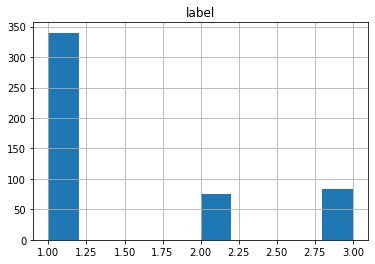

In [6]:
#Labels
data1.hist(column="label")

In [7]:
#Text
for i in range(0,12):
    print(data1.text[i])
data1.text[1].encode('unicode-escape')

Racist is just a catch phrase for control of populations.  China has shut off travel to and from Wuhan without a health screening. N. Korea shut off all travel to and from Wuhan Australia is now screening all flights from Wuhan  At some point PC is nothing but a mind control word
There's a trail that MSS is checking that allowed the designer-bioweapon into China in the first place. In my opinion, CIA introduced SARS targeting China previously. Novel Coronavirus is round 2, another destabilizing mega-weapon in their godless inhuman arsenal! IMPO 🇨🇳🕵️‍♀️
Why didn’t any of the “spiritual mediums” predict the #2020 #CoronavirusOutbreak? Not even with “I feel the letters C and V, they will become important”? Well, because there r no valid “mediums”. But if you know somebody who did and is (valid medium) please reply here. 🔮 #Corona
sfw?  defend the coincidence of Corona, Wuhan Lab, Gates Foundation, Pirbright Inst., and timing of many deep state implosions in recent weeks.   Dial a distract

b"There's a trail that MSS is checking that allowed the designer-bioweapon into China in the first place. In my opinion, CIA introduced SARS targeting China previously. Novel Coronavirus is round 2, another destabilizing mega-weapon in their godless inhuman arsenal! IMPO \\U0001f1e8\\U0001f1f3\\U0001f575\\ufe0f\\u200d\\u2640\\ufe0f"

Notes on this :
* there are emojis still in the text : remove at cleaning or take into account ?
* how to clean the # : #CoronavirusOutbreak in tweet 3 a word of the sentence, but needs to be split
* the capitalisation of some words ?

## Corrélation presence d'emoji-conspiracy

Question : les emojis sont-ils symptomatiques d'appels a l'emotion et donc peut etre de conspirations.

Reponse : nope. Il faudrait peut etre garder les emojis de facon plus sematique (quels emojis pour quel type de tweet ?)

In [8]:
# correlation of presence of emojis and conspiracy theories
def text_has_emoji(text):
    """ Very crude way of doing it, but the "emoji" library wasn't working according to plan
    """
    unicode_text = text.encode('unicode-escape')
    if b"\\u" in unicode_text:
        return 1
    return 0

data1["emoji_present"] = data1.text.apply(lambda x : text_has_emoji(x))
contigency_table = pd.crosstab(index=data1['label'], columns=data1['emoji_present'])
contigency_table

emoji_present,0,1
label,,
1,225,115
2,48,28
3,66,18


In [9]:
chi2, p, dof, expected = chi2_contingency(contigency_table, correction=False, lambda_=None)
print(chi2, p, dof, expected)
#Test of independance of the distributions
#The null hypothesis of the Chi-Square test is that no relationship exists on the categorical variables in the population; they are independent.

#returns 
# - chi2     The test statistic.
# - p        The p-value of the test
# - dof      Degrees of freedom
# - expected The expected frequencies, based on the marginal sums of the table.

# The p-value is >0.05, therefore we cannot reject H0 : presence of emoji and label are independent.

5.624833518186845 0.06005966710837437 2 [[230.52  109.48 ]
 [ 51.528  24.472]
 [ 56.952  27.048]]


In [10]:
# V de Cramer (mesure l'association entre les variables, meilleur que stat du chi2 parce stable en rapport de la taille de la table)
n = contigency_table.sum().sum()
phi2 = chi2/n
r,k = contigency_table.shape
phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
rcorr = r - ((r-1)**2)/(n-1)
kcorr = k - ((k-1)**2)/(n-1)
V = np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
print(V)

#rappel : Plus V est proche de zéro, plus il y a indépendance entre les deux variables étudiées. Il vaut 1 en cas de complète dépendance

#Donc c'est cramé (haha) pour les dependeances emoji-label

0.08518328751691673


## Relation type d'emojis - type de conspiration

In [11]:
import emoji
import regex

def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)
    
    return emoji_list

In [12]:
data1["emojis"] = data1.text.apply(lambda x : split_count(x))
data1.head(20)
list_all_emojis = list(set([emoji for sublist in data1["emojis"].tolist() for emoji in sublist]))

In [13]:
#Maintenant on compte : quel emoji apparait dans quel type de tweets ?
repartition_emojis={1:{}, 2:{}, 3:{}}

for row in data1.itertuples():
    label = row.label
    if len(row.emojis)>0:
        for emoji in row.emojis:
            if emoji in repartition_emojis[label].keys():
                repartition_emojis[label][emoji]+=1
            else :
                repartition_emojis[label][emoji]=1

In [14]:
for i in range(1,4):
    print("For label :", label_dict[i])
    print([(k,v) for k, v in sorted(repartition_emojis[i].items(), key=lambda item: item[1], reverse=True)][0:10])

For label : Non-Conspiracy
[('😂', 11), ('✅', 5), ('\U0001f92c', 3), ('😉', 2), ('😀', 2), ('⬇️', 2), ('😃', 2), ('😇', 2), ('🤦\u200d♂️', 2), ('😅', 2)]
For label : Discusses Conspiracy
[('🤣', 5), ('🙄', 3), ('🤦🏻\u200d♀️', 1), ('😈', 1), ('😤', 1), ('👏', 1), ('😕', 1), ('😠', 1), ('™', 1)]
For label : Promotes/Supports Conspiracy
[('\U0001f92a', 2), ('😳', 2), ('🙄', 2), ('💔', 1), ('😰', 1), ('🤔', 1), ('🤦\u200d♀️', 1), ('😤', 1), ('🙏', 1), ('❤️', 1)]


\U0001f92a : GRINNING FACE WITH ONE LARGE AND ONE SMALL EYE (http://www.iemoji.com/view/emoji/2488/smileys-people/crazy-face)
\U0001f92c : SERIOUS FACE WITH SYMBOLS COVERING MOUTH (https://www.fileformat.info/info/unicode/char/1f92c/index.htm)



Notes: le face palm est courant partout

Conclusion : on peut retirer les emojis sans trop affecter le texte/ le sens ici. De toute façon, il y a trop peu de textes avec emojis pour pouvoir les utiliser à fond.

Mais peut-on les garder et les traiter comme des mots ?

## Correlation majuscules - conspiration

In [15]:
list_covid = ["COVID", "COVID-19","COVID19","WHO", "CDC", "CIA", "SARS", "BTW"]
def has_all_caps_word(text):
    words = text.split(" ")
    for word in words :
        if ((word.isupper())&(word not in list_covid)&(len(word)>2)):
            return 1
    return 0

data1["has_all_caps"] = data1.text.apply(lambda x : has_all_caps_word(x))

In [16]:
#number of texts with all caps
len(data1[data1.has_all_caps==1].text.tolist())

181

In [17]:
#contigency table, le retour
contigency_table = pd.crosstab(index=data1['label'], columns=data1['has_all_caps'])
contigency_table

has_all_caps,0,1
label,,
1,220,120
2,52,24
3,47,37


In [18]:
chi2, p, dof, expected = chi2_contingency(contigency_table, correction=False, lambda_=None)
print(chi2, p, dof, expected)
n = contigency_table.sum().sum()
phi2 = chi2/n
r,k = contigency_table.shape
phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
rcorr = r - ((r-1)**2)/(n-1)
kcorr = k - ((k-1)**2)/(n-1)
V = np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
print(V)

#The null hypothesis of the Chi-Square test is that no relationship exists on the categorical variables in the population; they are independent.
#La p-value est >> 0.05, on ne peut pas rejetter HO, il n'y a pas de lien linéaire entre labels et all caps.

3.0633869330551633 0.21616928172980407 2 [[216.92  123.08 ]
 [ 48.488  27.512]
 [ 53.592  30.408]]
0.04607615834517353


In [19]:
#Number of all caps words in each tweet 
# L'intuition ici, c'est que les conspirations ont peut-être tendance à utiliser quelques mots en majuscules ("they want to CONTROL US", "doubt EVERYTHING") 
# tandis que les gens juste enervés écrivent tout le message en majuscules

def num_words_all_caps(text):
    num=0
    words = text.split(" ")
    for word in words :
        if (word.isupper()):
            num+=1
    return num

data1["num_all_caps"] = data1.text.apply(lambda x : num_words_all_caps(x))

In [ ]:
import statsmodels.api as sm

X = data1.num_all_caps
y = data1.label

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

#The null hypothesis states that all coefficients in the model are equal to zero.
#P>|t| is the p-value. It is > 0.05, so we cannot reject H0 : no link between number of all caps and label

                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.250
Date:                Wed, 29 Sep 2021   Prob (F-statistic):             0.0720
Time:                        17:17:45   Log-Likelihood:                -574.17
No. Observations:                 500   AIC:                             1152.
Df Residuals:                     498   BIC:                             1161.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.4596      0.038     38.772   

Les mots en all caps ne sont pas correles au label, que ce soit la presence de all caps ou leur nombre. 
On peut donc tout mettre en lowercase sans problemes.
Note: d'avoir lu les tweet en diagonale, les all caps sont souvent des gens en colere. Soit des conspirationistes, soit des gens opposes aux conspirations qui sont exasperes.

## Analyse du texte

In [ ]:
#Quel type de texte, de mots etc ?
def loadGloveModel(file):
    print("Loading Glove Model")
    model = KeyedVectors.load_word2vec_format(file, binary=True)
    print("Loaded")
    return model

wordvectors = loadGloveModel("/home/cyrielle/Codes/data/GoogleNews-vectors-negative300.bin")

In [30]:
wholetext = data1.text.tolist()
wholetext = " ".join(wholetext)

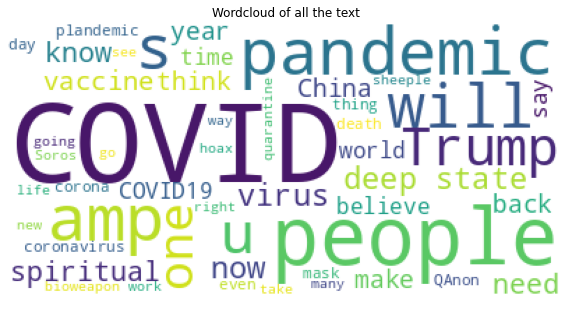

In [47]:
#To check the most common words, and complete the stop_words lists accordingly
wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(wholetext)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.imshow(wordcloud)
ax.axis("off")
plt.title("Wordcloud of all the text")
plt.show()

In [94]:
import string
def clean_text(text):
    #remove all punctuation
    exclude = set(string.punctuation)
    text = ''.join(ch for ch in text if ch not in exclude)
    #and this annoying thing ’ and ‘
    text = text.replace("’", "'")
    text = text.replace("‘", "'")
    #replace all the \' by the ' they are supposed to be
    text = text.replace("\'", "'")
    
    #remove the one-letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] ) #une regex est surement mieux, mais la flemme
    #remove html taggin that stayed behind
    text = text.replace("&amp;", "&")
    return text

In [102]:
stop_words = get_stop_words('en')
stop_words.append('will')
stop_words.append('covid') #parce que c'est le denominateur commun de tous ces tweets
stop_words.append("covid19")
stop_words.append("people")

In [103]:
text_conspiracy = clean_text(" ".join(data1.text[data1.label==3].tolist()).lower())
text_no_conspiracy = clean_text(" ".join(data1.text[data1.label==1].tolist()).lower())
text_talk_conspiracy = clean_text(" ".join(data1.text[data1.label==2].tolist()).lower())
#print(text_conspiracy)

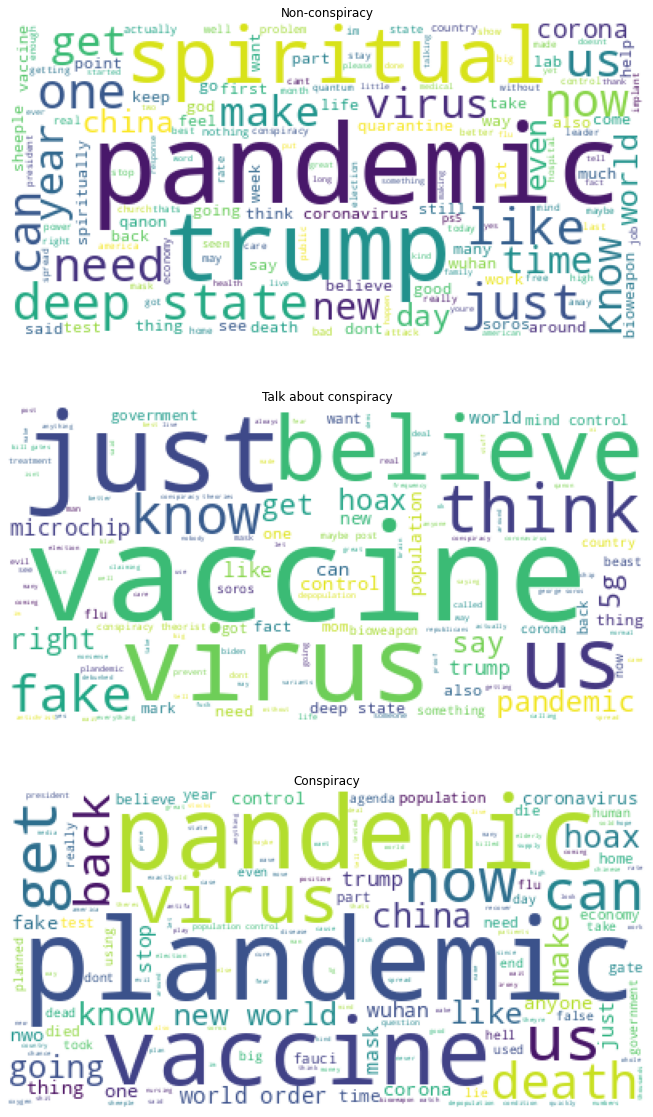

In [104]:
wordcloud1 = WordCloud(background_color = 'white', stopwords = stop_words, max_words = 150).generate(text_no_conspiracy)
wordcloud2 = WordCloud(background_color = 'white', stopwords = stop_words, max_words = 150).generate(text_talk_conspiracy)
wordcloud3 = WordCloud(background_color = 'white', stopwords = stop_words, max_words = 150).generate(text_conspiracy)
fig = plt.figure(figsize = (20,20))

ax1 = fig.add_subplot(311)
ax1.imshow(wordcloud1)
ax1.title.set_text('Non-conspiracy')
ax1.axis("off")

ax2 = fig.add_subplot(312)
ax2.imshow(wordcloud2)
ax2.title.set_text('Talk about conspiracy')
ax2.axis("off")

ax3 = fig.add_subplot(313)
ax3.imshow(wordcloud3)
ax3.title.set_text('Conspiracy')
ax3.axis("off")

plt.show()

Notes : the word "plandemic" is huge for the conspiracy... So is "vaccine" for the tweets that talk about conspiracy
There is a clear divide in the vocabulary used by labels 2 and 3


SHould we remove the words "people" ? It seems to be really common across all texts.

# Deuxieme dataset

In [ ]:
data2 = pd.read_csv("dev-1/dev-1-task-2.csv", header=None)

In [ ]:
"""
TweetID - a FakeNews task internal tweet ID, do not match with the original tweet ID.
Binary Flag for Suppressed cures - a flag indicating that the correcponding conspiracy theory is mentioned in the papticular tweet, 
Binary Flag for Behaviour and Mind Control - a flag indicating that the correcponding conspiracy theory is mentioned in the rapticular tweet.
Binary Flag for Antivax - a flag indicating that the correcponding conspiracy theory is mentioned in the rapticular tweet.
Binary Flag for Fake virus* - a flag indicating that the correcponding conspiracy theory is mentioned in the rapticular tweet.
Binary Flag for Intentional Pandemic - a flag indicating that the correcponding conspiracy theory is mentioned in the rapticular tweet.
Binary Flag for Harmful Radiation/ Influence - a flag indicating that the correcponding conspiracy theory is mentioned in the rapticular tweet.
Binary Flag for Population reduction - a flag indicating that the correcponding conspiracy theory is mentioned in the rapticular tweet.
Binary Flag for New World Order - a flag indicating that the correcponding conspiracy theory is mentioned in the rapticular tweet.
Binary Flag for Satanism - a flag indicating that the correcponding conspiracy theory is mentioned in the rapticular tweet.
Tweet Text - full tweet text block. Note that this field ends with the end of the CSV file line and it can contain extra commas that are not separators.

/!\ here 1 == mentioned, 0 == not mentioned (the same for the following Binary Flag fields).
"""
theories = ['supressed_cures', 'behaviour_mind_control', 'antivax', 'fake_virus', 
                'intentional_pandemic', 'harmful_radiation', 'population_reduction', 'new_world_order', 'satanism']
                
data2.columns = ['tweetid', 'supressed_cures', 'behaviour_mind_control', 'antivax', 'fake_virus', 
                'intentional_pandemic', 'harmful_radiation', 'population_reduction', 'new_world_order', 'satanism', 'text']


In [ ]:
#Basics
print(data2.shape)

#Does all tweet relate to a theory ?
data2_no_theory = data2[~data2[theories].any(axis='columns')]
print(data2_no_theory.shape)

#Does a tweet have more than one theory in it ?
temp_col = data2[theories].sum(axis=1)
data2_more_than_one_theory = data2[temp_col>1]
print(data2_more_than_one_theory.shape)

#Curiosite morbide : que racontent les doubles conspirationistes ?
#for item in data2_more_than_one_theory.text:
    #print(item)


(500, 11)
(340, 11)
(41, 11)


Notes : on a donc 340 tweets sur 500 qui n'ont aucune theorie du complot dedans, soit 68%
En plus, 41 sont des doubles conspirations, soit 8.2%. O joie

Attention ! Les doubles conspirations sont souvent des tweets de gens qui se moquent des complots / rectifient des theories du complot, et donc en 1 tweet incluent beaucoup de theories. Ce ne sont pas tous des gens qui croient a la 5G satanique cree par Bill Gates pour controler la population. Il y en a, mais pas tous.

In [ ]:
#Quelles sont les thories les plus populaires ?
number_theories = {}
for theory in theories :
    number_theories[theory] = data2[theory].sum()

[print(k, ":", v) for k, v in sorted(number_theories.items(), key=lambda item: item[1], reverse=True)]

fake_virus : 47
intentional_pandemic : 39
antivax : 30
behaviour_mind_control : 24
population_reduction : 20
new_world_order : 19
harmful_radiation : 15
satanism : 15
supressed_cures : 6


[None, None, None, None, None, None, None, None, None]

# Troisieme dataset

In [12]:
data3 = pd.read_csv("data/dev-1/dev-1-task-3.csv", header=None)

In [13]:
"""
TweetID - a FakeNews task internal tweet ID, do not match with the original tweet ID.
Class Label for Suppressed cures - a class identifier value for the correcponding conspiracy theory in the papticular tweet, 
Class Label for Behaviour and Mind Control - a class identifier value for the correcponding conspiracy theory in the papticular tweet.
Class Label for Antivax - a class identifier value for the correcponding conspiracy theory in the papticular tweet.
Class Label for Fake virus* - a class identifier value for the correcponding conspiracy theory in the papticular tweet.
Class Label for Intentional Pandemic - a class identifier value for the correcponding conspiracy theory in the papticular tweet.
Class Label for Harmful Radiation/ Influence - a class identifier value for the correcponding conspiracy theory in the papticular tweet.
Class Label for Population reduction - a class identifier value for the correcponding conspiracy theory in the papticular tweet.
Class Label for New World Order - aa class identifier value for the correcponding conspiracy theory in the papticular tweet.
Class Label for Satanism - a class identifier value for the correcponding conspiracy theory in the papticular tweet.
Tweet Text - full tweet text block. Note that this field ends with the end of the CSV file line and it can contain extra commas that are not separators.

/!\ here 3 == Promotes/Supports Conspiracy, 2 == Discusses Consparacy, 1 == Non-Conspiracy (the same for the following Class Label fields).
"""

theories = ['supressed_cures', 'behaviour_mind_control', 'antivax', 'fake_virus', 
                'intentional_pandemic', 'harmful_radiation', 'population_reduction', 'new_world_order', 'satanism']
                
data3.columns = ['tweetid', 'supressed_cures', 'behaviour_mind_control', 'antivax', 'fake_virus', 
                'intentional_pandemic', 'harmful_radiation', 'population_reduction', 'new_world_order', 'satanism', 'text']